In [ ]:
import models_partc
from sklearn.model_selection import KFold, ShuffleSplit
from numpy import mean

import utils

# USE THE GIVEN FUNCTION NAME, DO NOT CHANGE IT

# USE THIS RANDOM STATE FOR ALL OF YOUR CROSS VALIDATION TESTS, OR THE TESTS WILL NEVER PASS
RANDOM_STATE = 545510477

#input: training data and corresponding labels
#output: accuracy, auc
def get_acc_auc_kfold(X,Y,k=5):
    #TODO:First get the train indices and test indices for each iteration
    #Then train the classifier accordingly
    #Report the mean accuracy and mean auc of all the folds
    auc_list = []
    acc_list = []
    folds = KFold(n_splits=k, random_state = RANDOM_STATE)
    for train_index, test_index in folds.split(X):
        Y_pred = models_partc.logistic_regression_pred(X[train_index], 
                                                       Y[train_index], 
                                                       X[test_index])
        auc_list.append(models_partc.roc_auc_score(Y[test_index], Y_pred))
        acc_list.append(models_partc.accuracy_score(Y[test_index], Y_pred))
    return mean(acc_list),mean(auc_list)


#input: training data and corresponding labels
#output: accuracy, auc
def get_acc_auc_randomisedCV(X,Y,iterNo=5,test_percent=0.2):
    #TODO: First get the train indices and test indices for each iteration
    #Then train the classifier accordingly
    #Report the mean accuracy and mean auc of all the iterations
    auc_list = []
    acc_list = []
    folds = ShuffleSplit(n_splits=5, test_size=test_percent, random_state=RANDOM_STATE)
    for train_index, test_index in folds.split(X):
        Y_pred = models_partc.logistic_regression_pred(X[train_index], 
                                                       Y[train_index], 
                                                       X[test_index])
        auc_list.append(models_partc.roc_auc_score(Y[test_index], Y_pred))
        acc_list.append(models_partc.accuracy_score(Y[test_index], Y_pred))
    return mean(acc_list),mean(auc_list)


def main():
    X,Y = utils.get_data_from_svmlight("../deliverables/features_svmlight.train")
    print("Classifier: Logistic Regression__________")
    acc_k,auc_k = get_acc_auc_kfold(X,Y)
    print(("Average Accuracy in KFold CV: "+str(acc_k)))
    print(("Average AUC in KFold CV: "+str(auc_k)))
    acc_r,auc_r = get_acc_auc_randomisedCV(X,Y)
    print(("Average Accuracy in Randomised CV: "+str(acc_r)))
    print(("Average AUC in Randomised CV: "+str(auc_r)))

if __name__ == "__main__":
    main()



In [ ]:
X,Y = utils.get_data_from_svmlight("../deliverables/features_svmlight.train")

In [100]:
import utils
from etl import *
import pandas as pd
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
import warnings

warnings.filterwarnings('ignore')

random_state = 49
#Note: You can reuse code that you wrote in etl.py and models.py and cross.py over here. It might help.
# PLEASE USE THE GIVEN FUNCTION NAME, DO NOT CHANGE IT

'''
You may generate your own features over here.
Note that for the test data, all events are already filtered such that they fall in the observation window of their respective patients. Thus, if you were to generate features similar to those you constructed in code/etl.py for the test data, all you have to do is aggregate events for each patient.
IMPORTANT: Store your test data features in a file called "test_features.txt" where each line has the
patient_id followed by a space and the corresponding feature in sparse format.
Eg of a line:
60 971:1.000000 988:1.000000 1648:1.000000 1717:1.000000 2798:0.364078 3005:0.367953 3049:0.013514
Here, 60 is the patient id and 971:1.000000 988:1.000000 1648:1.000000 1717:1.000000 2798:0.364078 3005:0.367953 3049:0.013514 is the feature for the patient with id 60.

Save the file as "test_features.txt" and save it inside the folder deliverables

input:
output: X_train,Y_train,X_test
'''
def my_features():
    #TODO: complete this
    train_path = '../deliverables/features_svmlight.train'
    test_path = '../data/test/'

    #load train data
    X_train, Y_train = utils.get_data_from_svmlight(train_path)

    #load test data
    events_test = pd.read_csv(test_path + 'events.csv')
    efm_test = pd.read_csv(test_path + 'event_feature_map.csv')


    #create features from test data
    def create_test_features(events, feature_map):
        aggregated_events = aggregate_events(events, '_', feature_map, '_')
        grp = aggregated_events.groupby('patient_id').agg(list)
        def tuples(x,y):
            return zip(x,y)
        patient_features = pd.Series.to_dict(grp[['feature_id','feature_value']].apply(lambda x: list(tuples(*x)), axis = 1))
        return patient_features

    patient_test_features = create_test_features(events_test, efm_test)

    #save test features
    def save_test_features_svm(features, output):
        file = open(output, 'wb')
        #svm format for test_features
        for k in features.keys():
            features[k] = sorted(features[k])
            file.write(bytes(("{} ".format(int(k))),'UTF-8'))
            for v in features[k]:
                file.write(bytes(("{}:{:.6f} ".format(v[0],v[1])),'UTF-8'))
            file.write(bytes(("\n"),'UTF-8'))
        file.close()


    save_test_features_svm(patient_test_features, "../deliverables/test_features.txt")

    #load X_test from svmlight
    X_test = load_svmlight_file("../deliverables/test_features.txt", n_features=3190)[0]
    
    return X_train,Y_train,X_test


'''
You can use any model you wish.

input: X_train, Y_train, X_test
output: Y_pred
'''
def my_classifier_predictions(X_train,Y_train,X_test):
    
    pca = PCA(n_components = 45)
    pca.fit(X_train.toarray())
    X_train = pca.transform(X_train.toarray())
    X_test = pca.transform(X_test.toarray())
    
    #generate best svm estimator
    print('Generating best svm estimator via Gridsearch')
    pipe = Pipeline([('classify', SVC(probability=True, random_state=random_state))])
    param_grid = [{'classify__C':[0.01,0.1,1,10,100]}]
    svc_clf = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, return_train_score=True)
    svc_clf.fit(X_train, Y_train)
    svm = svc_clf.best_estimator_
    

    #generate best random forest estimator
    print('Generating best random forest estimator via Gridsearch')
    param_grid = {'n_estimators':[100,200,300,400,500],
                  'max_leaf_nodes':[5,10,15,20,25]}
    forest_clf = RandomForestClassifier(random_state=random_state)
    forest_cv = GridSearchCV(forest_clf, param_grid = param_grid, cv=5)
    forest_cv.fit(X_train, Y_train)
    rf = forest_cv.best_estimator_
    
    #generate best gradient boosted estimator
    print('Generating best gradient boosted estimator via Gridsearch')
    param_grids = {
                   'max_depth':[1,5,10,15],
                   'n_estimators':[2,3,4,5],
                   }

    boost_clf = GradientBoostingClassifier(random_state=random_state)
    boost_cv = GridSearchCV(boost_clf, param_grid=param_grids, cv = 5)
    boost_cv.fit(X_train,Y_train)
    gb = boost_cv.best_estimator_
    
    #generate best multi-layered perceptron estimator
    print('Generating best Multi-Layered Perceptron estimator via Gridsearch - This might take awhile')
    param_grids = {
                    'activation': [ 'tanh', 'relu'],
                    'solver': ['lbfgs', 'sgd', 'adam'],
                    'learning_rate': ['adaptive'],
                    'hidden_layer_sizes': [(5,2), (10,5,2)]
    }
    
    nn_clf = MLPClassifier(random_state = random_state)
    nn_cv = GridSearchCV(nn_clf, param_grid=param_grids, cv =5)
    nn_cv.fit(X_train, Y_train)
    nn = nn_cv.best_estimator_
    
    #generate best adaboost classifier
    print('Generating best Adaboost estimator via Gridsearch')
    param_grids = {
                    'n_estimators': [10,30,50,70],
                    'algorithm': ['SAMME', 'SAMME.R']
    }
    
    ab_clf = AdaBoostClassifier(random_state = random_state)
    ab_cv = GridSearchCV(ab_clf, param_grid=param_grids, cv = 5)
    ab_cv.fit(X_train, Y_train)
    ab = ab_cv.best_estimator_
    
    #generate best logistic regression estimator
    print('Generating best logistic regression estimator via Gridsearch')
    param_grids = {
                   'penalty':['l1', 'l2'],
                   'C':[0.01,0.1,1, 10, 100]
                   }
    lr_clf = LogisticRegression(random_state=random_state)
    lr_cv = GridSearchCV(lr_clf, param_grid=param_grids, cv = 5)
    lr_cv.fit(X_train,Y_train)
    lr = lr_cv.best_estimator_
    
    #generate naive bayes estimator
    print('Generating Naive Bayes estimator via Gridsearch')
    nb_clf = GaussianNB()
    nb_clf.fit(X_train,Y_train)
    nb = nb_clf
    
    param_grid = {
        'max_iter_predict':[100,300,500]
    }
    gpc = GaussianProcessClassifier(random_state=random_state)
    gp_cv = GridSearchCV(gpc, param_grid=param_grid, cv=5)
    gp_cv.fit(X_train, Y_train)
    gpc = gp_cv.best_estimator_
    

    
    
    #create ensemble classifier
    print('Compiling Ensemble Voters')
    estimators=[('gpc', gpc), ('ab', ab), ('nn', nn), ('svm', svm), ('random_forest', rf), ('gradient_boost', gb), ('logistic_regression', lr), ('naive_bayes', nb)]
    ensemble = VotingClassifier(estimators, voting='soft')
    ensemble.fit(X_train, Y_train)
    print('Prediction Complete')
    
    return ensemble.predict_proba(X_test)[:,1], ensemble, ab, nn, svm, rf, gb, lr, nb, gpc


def main():
    X_train, Y_train, X_test = my_features()
    Y_pred, ensemble, ab, nn, svm, rf, gb, lr, nb, gpc = my_classifier_predictions(X_train,Y_train,X_test)
    utils.generate_submission("../deliverables/test_features.txt",Y_pred)
    #The above function will generate a csv file of (patient_id,predicted label) and will be saved as "my_predictions.csv" in the deliverables folder.
    return Y_pred, ensemble, ab, nn, svm, rf, gb, lr, nb, gpc
if __name__ == "__main__":
    y_pred, ensemble, ab, nn, svm, rf, gb, lr, nb, gpc = main()


Generating best svm estimator via Gridsearch
Generating best random forest estimator via Gridsearch
Generating best gradient boosted estimator via Gridsearch
Generating best Multi-Layered Perceptron estimator via Gridsearch - This might take awhile
Generating best Adaboost estimator via Gridsearch
Generating best logistic regression estimator via Gridsearch
Generating Naive Bayes estimator via Gridsearch
Compiling Ensemble Voters
Prediction Complete


In [101]:
gpc

GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=1,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=49, warm_start=False)

In [76]:
param_grid = {
    'n_restarts_optimizer' : [0,5,10,20],
    'max_iter_predict': [100,300,500],
    
}

gpc = GaussianProcessClassifier(random_state=random_state)
gp_cv = GridSearchCV(gpc, param_grid=param_grid, cv=5)
gp_cv.fit(xtr.toarray(), ytr)
gp_cv.best_estimator_

GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=1,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=42, warm_start=False)

In [42]:
y_

array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0.

In [75]:
print(svm, '\n\n', rf, '\n\n', gb, '\n\n', lr, '\n\n', nb)

Pipeline(memory=None,
     steps=[('classify', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0))]) 

 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=25,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False) 

 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_wei

In [8]:
xtr,ytr,xtst = my_features()

In [139]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def pca_model_eda(x_cols):
    
    pca = PCA()
    pca.fit(x_cols)

    # Do the rest on your own :)
    var = pca.explained_variance_
    fig = plt.figure(figsize = (20,15))
    plt.plot(range(len(var)),var, marker ='o')
    plt.scatter(40, var[40], marker='*', s = 500, c='r')
    plt.arrow(200,0.2,-160, -(0.2 - var[40]), head_width=0.01, head_length=0.3, fc='k', ec='k')
    plt.text(201,0.2, 'Possible Optimal Components: {}'.format(40),fontsize=18)
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.title('PCA Elbow Chart')
    plt.show()


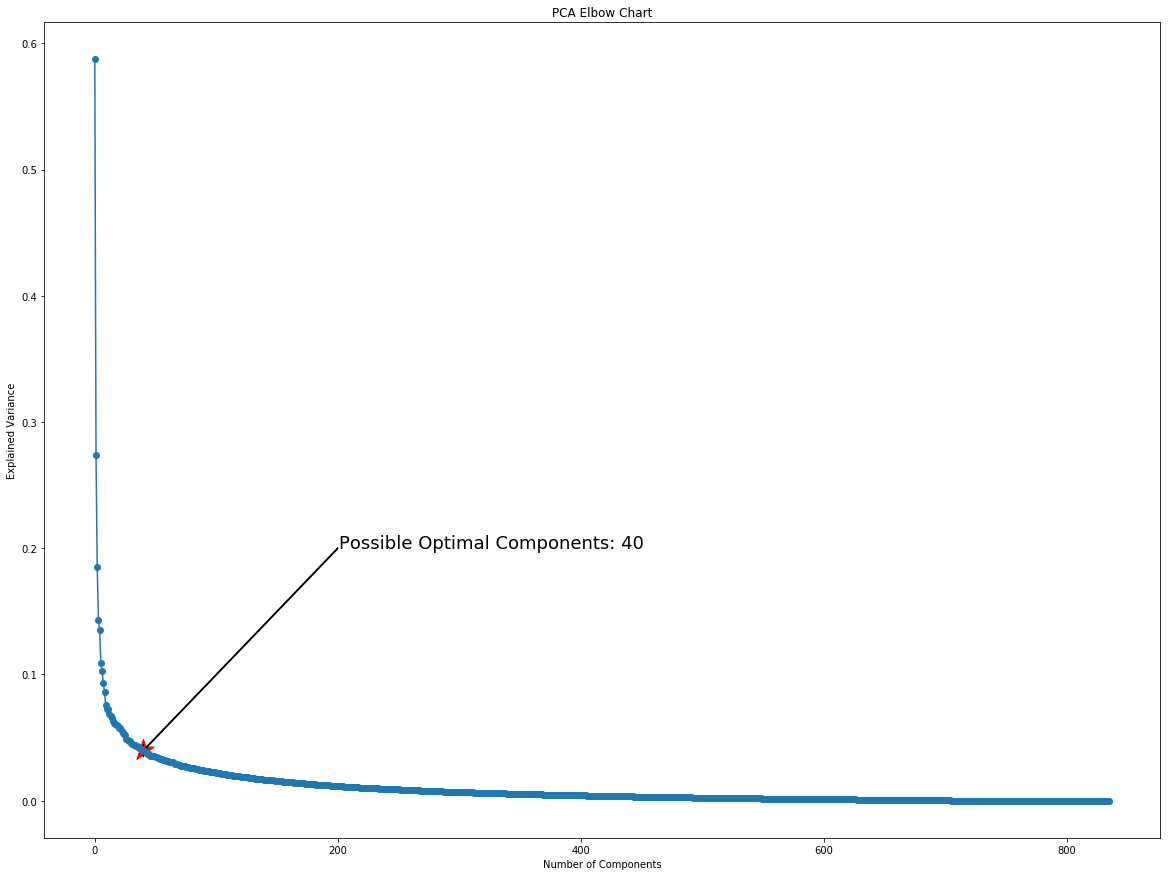

In [140]:
pca_model_eda(xtr.toarray())

In [131]:
pca = PCA(n_components = 40)
pca.fit(xtr.toarray())
tr = pca.transform(xtr.toarray())
ts = pca.transform(xtst.toarray())

# SVM

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt

Best CV Accuracy Score: 0.7392344497607656
             precision    recall  f1-score   support

        0.0       0.86      0.96      0.91       500
        1.0       0.93      0.76      0.84       336

avg / total       0.89      0.88      0.88       836

Full Train Data Accuracy: 0.8827751196172249
AUC: 0.8629523809523809


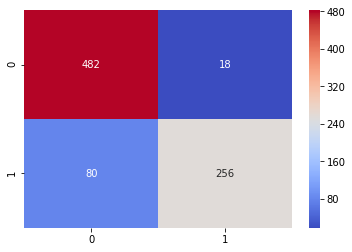

In [79]:
pipe = Pipeline([
    
    ('classify', (LinearSVC(random_state=random_state)))
])

param_grid = [{'classify__C':[0.01,0.1,1,10,100]}]
svc_clf = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, return_train_score=True)
svc_clf.fit(xtr.toarray(),ytr)
svm_preds = svc_clf.predict(xtr.toarray())
print('Best CV Accuracy Score: {}'.format(svc_clf.best_score_))
print(classification_report(ytr, svm_preds))
print('Full Train Data Accuracy: {}'.format(accuracy_score(ytr,svm_preds)))
print('AUC: {}'.format(roc_auc_score(ytr, svm_preds)))
sns.heatmap(confusion_matrix(ytr, svm_preds),annot=True, fmt = 'd', xticklabels = [0,1],  yticklabels = [0,1], cmap = 'coolwarm')
plt.show()

# SVM w/ PCA

In [201]:
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

In [202]:
pca_pipe = Pipeline([
    
    ('reduce_dim',PCA()),
    ('classify',LinearSVC())
])

In [203]:
N_FEATURES_OPTIONS = [20, 30, 40]
C_OPTIONS = [0.01,0.1,1, 10, 100, 1000]

In [204]:

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    }
]

In [205]:
svm_decomp = GridSearchCV(pca_pipe, cv=5, n_jobs=1, param_grid=param_grid)

In [206]:
svm_decomp.fit(xtr.toarray(), ytr)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power=7, n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=40, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, v... at 0x7fd6f0fbf378>)], 'reduce_dim__k': [20, 30, 40], 'classify__C': [0.01, 0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scorin

Best CV Accuracy Score: 0.7212918660287081
             precision    recall  f1-score   support

        0.0       0.77      0.84      0.80       500
        1.0       0.72      0.63      0.67       336

avg / total       0.75      0.75      0.75       836

Full Train Data Accuracy: 0.7535885167464115
AUC: 0.7334761904761905


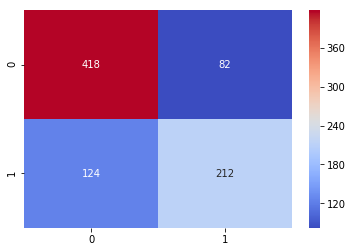

In [207]:
print('Best CV Accuracy Score: {}'.format(svm_decomp.best_score_))
decomp_preds = svm_decomp.predict(xtr.toarray())
decomp_accuracy = accuracy_score(ytr, decomp_preds)
print(classification_report(ytr, decomp_preds))
print('Full Train Data Accuracy: {}'.format(decomp_accuracy))
print('AUC: {}'.format(roc_auc_score(ytr, decomp_preds)))
sns.heatmap(confusion_matrix(ytr, decomp_preds),annot=True, fmt = 'd', xticklabels = [0,1],  yticklabels = [0,1], cmap = 'coolwarm')
plt.show()

# Random Forest

In [208]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
param_grid = {'n_estimators':[100,200,300,400,500],
              'max_leaf_nodes':[5,10,15,20,25]}
forest_clf = RandomForestClassifier(random_state=random_state)
forest_cv = GridSearchCV(forest_clf, param_grid = param_grid, cv=5)
forest_cv.fit(xtr, ytr)
for_pred = forest_cv.predict(xtr)

Best CV Accuracy Score: 0.6949760765550239
             precision    recall  f1-score   support

        0.0       0.84      0.91      0.88       500
        1.0       0.85      0.75      0.80       336

avg / total       0.85      0.85      0.84       836

Full Train Data Accuracy: 0.8456937799043063
AUC: 0.8300000000000001


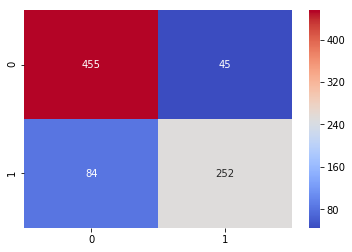

In [62]:
print('Best CV Accuracy Score: {}'.format(forest_cv.best_score_))
forest_accuracy = accuracy_score(ytr, for_pred)
print(classification_report(ytr, for_pred))
print('Full Train Data Accuracy: {}'.format(forest_accuracy))
print('AUC: {}'.format(roc_auc_score(ytr, for_pred)))
sns.heatmap(confusion_matrix(ytr, for_pred),annot=True, fmt = 'd', xticklabels = [0,1],  yticklabels = [0,1], cmap = 'coolwarm')
plt.show()

# Gradient Boosting

In [10]:

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

In [149]:
param_grids = {
               'max_depth':[1,5,10,15],
               'n_estimators':[2,3,4,5],
               }

boost_clf = GradientBoostingClassifier(random_state=random_state)
boost_cv = GridSearchCV(boost_clf, param_grid=param_grids, cv = 5)
boost_cv.fit(xtr,ytr)
boost_pred = boost_cv.predict(X_test)

Best CV Accuracy Score: 0.7057416267942583
             precision    recall  f1-score   support

        0.0       0.69      0.78      0.73       120
        1.0       0.65      0.53      0.59        90

avg / total       0.67      0.68      0.67       210

Full Train Data Accuracy: 0.6761904761904762
AUC: 0.6583333333333333


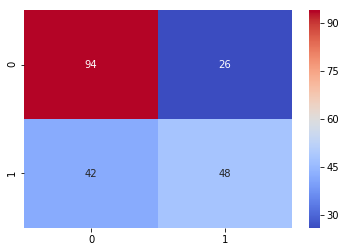

In [150]:
print('Best CV Accuracy Score: {}'.format(boost_cv.best_score_))
boost_accuracy = accuracy_score(Y_test, boost_pred)
print(classification_report(Y_test,boost_pred))
print('Full Train Data Accuracy: {}'.format(boost_accuracy))
print('AUC: {}'.format(roc_auc_score(Y_test, boost_pred)))
sns.heatmap(confusion_matrix(Y_test, boost_pred),annot=True, fmt = 'd', xticklabels = [0,1],  yticklabels = [0,1], cmap = 'coolwarm')
plt.show()

# Logistic Regression

In [186]:
from sklearn.linear_model import LogisticRegression

In [65]:
param_grids = {
               'penalty':['l1', 'l2'],
               'C':[0.01,0.1,1, 10, 100]
               }
lr_clf = LogisticRegression(random_state=random_state)
lr_cv = GridSearchCV(lr_clf, param_grid=param_grids, cv = 5)
lr_cv.fit(xtr,ytr)
lr_pred = lr_cv.predict(xtr)

Best CV Accuracy Score: 0.7057416267942583
             precision    recall  f1-score   support

        0.0       0.86      0.96      0.91       500
        1.0       0.94      0.77      0.85       336

avg / total       0.89      0.89      0.88       836

Full Train Data Accuracy: 0.8863636363636364
AUC: 0.8674166666666667


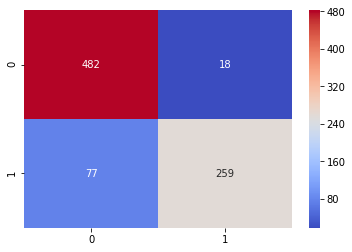

In [66]:
print('Best CV Accuracy Score: {}'.format(boost_cv.best_score_))
boost_accuracy = accuracy_score(ytr, lr_pred)
print(classification_report(ytr,lr_pred))
print('Full Train Data Accuracy: {}'.format(boost_accuracy))
print('AUC: {}'.format(roc_auc_score(ytr, lr_pred)))
sns.heatmap(confusion_matrix(ytr, lr_pred),annot=True, fmt = 'd', xticklabels = [0,1],  yticklabels = [0,1], cmap = 'coolwarm')
plt.show()

# K-Nearest Neighbors

In [152]:
from sklearn.neighbors import KNeighborsClassifier

In [216]:
param_grids = {
               'n_neighbors':[3,4,5,6,7,8,9,10],
               'p':[1,2]
               }
kn_clf = KNeighborsClassifier()
kn_cv = GridSearchCV(kn_clf, param_grid=param_grids, cv = 5)
kn_cv.fit(xtr,ytr)
kn_pred = kn_cv.predict(xtr)

Best CV Accuracy Score: 0.6447368421052632
             precision    recall  f1-score   support

        0.0       0.86      0.61      0.72       500
        1.0       0.60      0.85      0.70       336

avg / total       0.75      0.71      0.71       836

Full Train Data Accuracy: 0.7081339712918661
AUC: 0.7311071428571428


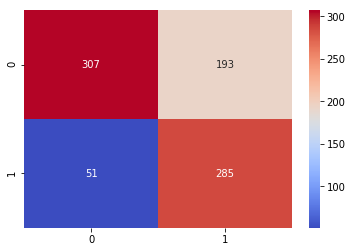

In [217]:
print('Best CV Accuracy Score: {}'.format(kn_cv.best_score_))
kn_accuracy = accuracy_score(ytr, kn_pred)
print(classification_report(ytr,kn_pred))
print('Full Train Data Accuracy: {}'.format(kn_accuracy))
print('AUC: {}'.format(roc_auc_score(ytr, kn_pred)))
sns.heatmap(confusion_matrix(ytr, kn_pred),annot=True, fmt = 'd', xticklabels = [0,1],  yticklabels = [0,1], cmap = 'coolwarm')
plt.show()

# Naive Bayes

In [193]:
from sklearn.naive_bayes import GaussianNB

In [67]:
nb_clf = GaussianNB()
nb_clf.fit(xtr.toarray(),ytr)
nb_pred = nb_clf.predict(xtr.toarray())

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94       500
        1.0       0.96      0.85      0.91       336

avg / total       0.93      0.93      0.93       836

Full Train Data Accuracy: 0.9282296650717703
AUC: 0.9160833333333332


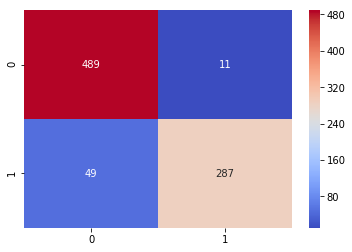

In [68]:
nb_accuracy = accuracy_score(ytr, nb_pred)
print(classification_report(ytr,nb_pred))
print('Full Train Data Accuracy: {}'.format(nb_accuracy))
print('AUC: {}'.format(roc_auc_score(ytr, nb_pred)))
sns.heatmap(confusion_matrix(ytr, nb_pred),annot=True, fmt = 'd', xticklabels = [0,1],  yticklabels = [0,1], cmap = 'coolwarm')
plt.show()

# Ensebmle

In [69]:
svm = svc_clf.best_estimator_
rf = forest_cv.best_estimator_
gb = boost_cv.best_estimator_
lr = lr_cv.best_estimator_
nb = nb_clf

In [107]:
clf = CalibratedClassifierCV(base_estimator=svm, cv='prefit')
clf.fit(xtr, ytr)

CalibratedClassifierCV(base_estimator=Pipeline(memory=None,
     steps=[('classify', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0))]),
            cv='prefit', method='sigmoid')

In [120]:
clf.

CalibratedClassifierCV(base_estimator=Pipeline(memory=None,
     steps=[('classify', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0))]),
            cv='prefit', method='sigmoid')

In [110]:
clf.predict(xtr)

array([1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 0.

             precision    recall  f1-score   support

        0.0       0.89      0.93      0.91       500
        1.0       0.88      0.84      0.86       336

avg / total       0.89      0.89      0.89       836

Full Train Data Accuracy: 0.8899521531100478
AUC: 0.8811547619047619


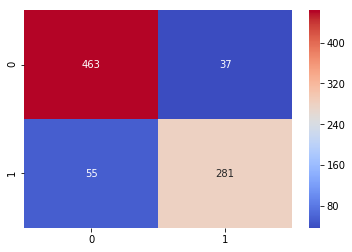

In [88]:
print(classification_report(ytr, pred))
print('Full Train Data Accuracy: {}'.format(accuracy_score(ytr,pred)))
print('AUC: {}'.format(roc_auc_score(ytr, pred)))
sns.heatmap(confusion_matrix(ytr, pred),annot=True, fmt = 'd', xticklabels = [0,1],  yticklabels = [0,1], cmap = 'coolwarm')
plt.show()

In [49]:
from sklearn.ensemble import VotingClassifier

In [70]:
estimators=[ ('random_forest', rf), ('gradient_boost', gb), ('logistic_regression', lr), ('naive_bayes', nb)]

In [71]:
ensemble = VotingClassifier(estimators, voting='hard')

In [72]:
ensemble.fit(xtr.toarray(), ytr)
ens_pred = ensemble.predict(xtst.toarray())

/home/scott/anaconda3/envs/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [73]:
ens_pred == Y_pred

NameError: name 'Y_pred' is not defined

In [232]:
roc_auc_score(ytr, ens_pred)

0.9101547619047619

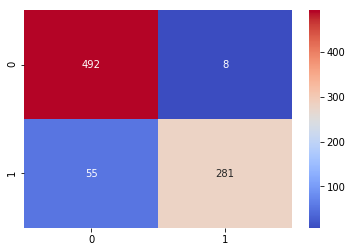

In [233]:
sns.heatmap(confusion_matrix(ytr, ens_pred),annot=True, fmt = 'd', xticklabels = [0,1],  yticklabels = [0,1], cmap = 'coolwarm')
